In [1]:
import caiman as cm
import os
import numpy as np

import h5py
import pickle
from pathlib import Path

import fastplotlib

import logging
import matplotlib.pyplot as plt
import numpy as np

# logging.basicConfig(format=
#                           "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
#                     # filename="/tmp/caiman.log",
# #                     level=logging.DEBUG)

# logging.getLogger('matplotlib.font_manager').disabled = True
# import caiman as cm

from caiman.source_extraction import cnmf
from caiman.utils.utils import download_demo
from caiman.utils.visualization import inspect_correlation_pnr, nb_inspect_correlation_pnr
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import params as params
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
import cv2

try:
    cv2.setNumThreads(0)
except:
    pass

from skimage import io

## Data loading

In [3]:
filepath = "Nikitas_mice/07_CA1_FS_2022_03_01_17_38_07_NR.tiff"
data = io.imread(filepath)

In [4]:
im = fastplotlib.ImageWidget(data)
im.show()

RFBOutputContext()

## Motion correction

In [5]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

/var/folders/wq/z0vgyyfs6vs7gy_wwb26bpp00000gn/T/ipykernel_7484/2795869343.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)


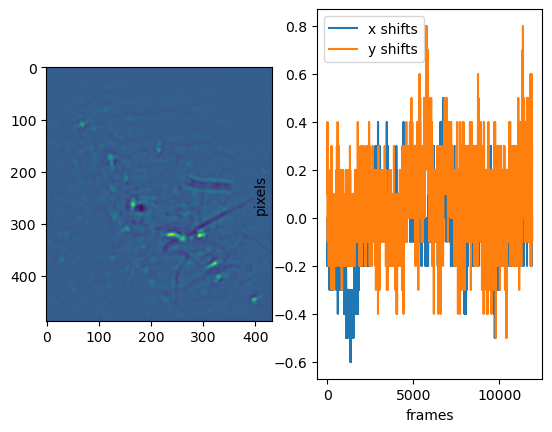

In [6]:
fnames = [filepath]


# dataset dependent parameters
frate = 30                       # movie frame rate
decay_time = 0.4                 # length of a typical transient in seconds

# motion correction parameters
motion_correct = True    # flag for performing motion correction
pw_rigid = False         # flag for performing piecewise-rigid motion correction (otherwise just rigid)
gSig_filt = (5, 5)       # size of high pass spatial filtering, used in 1p data
max_shifts = (35, 35)      # maximum allowed rigid shift
strides = (48, 48)       # start a new patch for pw-rigid motion correction every x pixels
overlaps = (24, 24)      # overlap between pathes (size of patch strides+overlaps)
max_deviation_rigid = 3  # maximum deviation allowed for patch with respect to rigid shifts
border_nan = 'copy'      # replicate values along the boundaries

mc_dict = {
    'fnames': fnames,
    'fr': frate,
    'decay_time': decay_time,
    'pw_rigid': pw_rigid,
    'max_shifts': max_shifts,
    'gSig_filt': gSig_filt,
    'strides': strides,
    'overlaps': overlaps,
    'max_deviation_rigid': max_deviation_rigid,
    'border_nan': border_nan
}

opts = params.CNMFParams(params_dict=mc_dict)


if motion_correct:
    # do motion correction rigid
    mc = MotionCorrect(fnames, dview=dview, **opts.get_group('motion'))
    mc.motion_correct(save_movie=True)
    fname_mc = mc.fname_tot_els if pw_rigid else mc.fname_tot_rig
    if pw_rigid:
        bord_px = np.ceil(np.maximum(np.max(np.abs(mc.x_shifts_els)),
                                     np.max(np.abs(mc.y_shifts_els)))).astype(np.int)
    else:
        bord_px = np.ceil(np.max(np.abs(mc.shifts_rig))).astype(np.int)
        plt.subplot(1, 2, 1); plt.imshow(mc.total_template_rig)  # % plot template
        plt.subplot(1, 2, 2); plt.plot(mc.shifts_rig)  # % plot rigid shifts
        plt.legend(['x shifts', 'y shifts'])
        plt.xlabel('frames')
        plt.ylabel('pixels')

    bord_px = 0 if border_nan == 'copy' else bord_px
    fname_new = cm.save_memmap(fname_mc, base_name='memmap_', order='C',
                               border_to_0=bord_px)
else:  # if no motion correction just memory map the file
    fname_new = cm.save_memmap(fnames, base_name='memmap_',
                               order='C', border_to_0=0, dview=dview)

In [7]:
# Load memmap file 
Yr, dims, T = cm.load_memmap(fname_new)
images = Yr.T.reshape((T,) + dims, order='F')

In [8]:
images_int = np.array(images,dtype=np.uint8) # This is to reduce the size an put the array into memory to display in seamlessly

In [9]:
mcorr_im = fastplotlib.ImageWidget([data,images_int])
mcorr_im.show()

RFBOutputContext()

## CNMF-E

In [ ]:
# --- Parameters for source extraction and deconvolution


p = 1               # order of the autoregressive system
K = 10              # upper bound on number of components per patch, in general None
gSig = (5, 5)       # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = (21, 21)     # average diameter of a neuron, in general 4*gSig+1
Ain = None          # possibility to seed with predetermined binary masks
merge_thr = 0.85     # merging threshold, max correlation allowed
rf = 30             # half-size of the patches in pixels. e.g., if rf=40, patches are 80x80
stride_cnmf = 21    # amount of overlap between the patches in pixels
#                     (keep it at least large as gSiz, i.e 4 times the neuron size gSig)
tsub = 1            # downsampling factor in time for initialization,
#                     increase if you have memory problems
ssub = 1            # downsampling factor in space for initialization,
#                     increase if you have memory problems
#                     you can pass them here as boolean vectors
low_rank_background = None  # None leaves background of each patch intact,
#                     True performs global low-rank approximation if gnb>0
gnb = 2             # number of background components (rank) if positive,
#                     else exact ring model with following settings
#                         gnb= 0: Return background as b and W
#                         gnb=-1: Return full rank background B
#                         gnb<-1: Don't return background
nb_patch = 0        # number of background components (rank) per patch if gnb>0,
#                     else it is set automatically
min_corr = .8       # min peak value from correlation image
min_pnr = 10        # min peak to noise ration from PNR image
ssub_B = 2          # additional downsampling factor in space for background
ring_size_factor = 1.4  # radius of ring is gSiz*ring_size_factor

opts.change_params(params_dict={'method_init': 'corr_pnr',  # use this for 1 photon
                                'K': K,
                                'gSig': gSig,
                                'gSiz': gSiz,
                                'merge_thr': merge_thr,
                                'p': p,
                                'tsub': tsub,
                                'ssub': ssub,
                                'rf': rf,
                                'stride': stride_cnmf,
                                'only_init': True,    # set it to True to run CNMF-E
                                'nb': gnb,
                                'nb_patch': nb_patch,
                                'method_deconvolution': 'oasis',       # could use 'cvxpy' alternatively
                                'low_rank_background': low_rank_background,
                                'update_background_components': True,  # sometimes setting to False improve the results
                                'min_corr': min_corr,
                                'min_pnr': min_pnr,
                                'normalize_init': False,               # just leave as is
                                'center_psf': True,                    # leave as is for 1 photon
                                'ssub_B': ssub_B,
                                'ring_size_factor': ring_size_factor,
                                'del_duplicates': True,                # whether to remove duplicates from initialization
                                'border_pix': bord_px})                # number of pixels to not consider in the borders)

In [ ]:
cnm = cnmf.CNMF(n_processes=n_processes, dview=dview, Ain=Ain, params=opts)
cnm.fit(images)

## Component evaluation

In [12]:
min_SNR = 3           # adaptive way to set threshold on the transient size
r_values_min = 0.95    # threshold on space consistency (if you lower more components
#                        will be accepted, potentially with worst quality)
cnm.params.set('quality', {'min_SNR': min_SNR,
                           'rval_thr': r_values_min,
                           'use_cnn': False})
cnm.estimates.evaluate_components(images, cnm.params, dview=dview)

print(' ***** ')
print('Number of total components: ', len(cnm.estimates.C))
print('Number of accepted components: ', len(cnm.estimates.idx_components))

 ***** 
Number of total components:  63
Number of accepted components:  15


In [52]:
spatial = cnm.estimates.A
temporal = cnm.estimates.C

Dump CNM data into pickle for further vizualization

In [ ]:
import pickle

In [16]:
with open("Nikitas_mice/CNM_07_CA1_FS_2022_03_01_17_38_07_NR.pickle", "wb") as f:
    pickle.dump(cnm.estimates, f)